# Project : portfolio trading
by Janvier Nils, Jeulin Marc and Romano Julien

### Import librairies

In [56]:
import pandas as pd
import glob,os
import numpy as np
import timeit
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

###  Reading the data

In [57]:
#path = os.getcwd()
extension = 'csv'

def getFiles():
    return glob.glob('chunk*.{}'.format(extension))

def prepareData():
    files = getFiles()
    list_of_df = []
    for file in files :
        data = pd.read_csv(file, index_col='Unnamed: 0')
        list_of_df.append(data)
    df = pd.concat(x for x in list_of_df)
    return df
df = prepareData()
df = df.sort_values('date')

In [58]:
fama_french_3 = pd.read_csv("F-F_Research_Data_Factors.CSV", index_col='Unnamed: 0', skiprows=3)
fama_french_3 = fama_french_3[:1124]
fama_french_3.index = pd.to_datetime(fama_french_3.index, format="%Y%m")

In [66]:
df

,date,PERMNO,SHRCD,EXCHCD,TICKER,PRC,VOL,RET,SHROUT,annual_return,rapm,z_score,momentum_score
0,1962-07,10006,10.0,1.0,NaN,67.5000,381.0,0.144068,1453.0,NaN,NaN,NaN,NaN
2057,1962-08,10006,10.0,1.0,NaN,67.1250,377.0,0.003704,1453.0,NaN,NaN,NaN,NaN
4122,1962-09,10006,10.0,1.0,NaN,63.5000,321.0,-0.054004,1453.0,NaN,NaN,NaN,NaN
6188,1962-10,10006,10.0,1.0,NaN,68.0000,402.0,0.070866,1453.0,NaN,NaN,NaN,NaN
8255,1962-11,10006,10.0,1.0,NaN,72.8750,621.0,0.080882,1453.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4217747,2019-12,19122,73.0,4.0,NaN,20.1000,2351.0,NaN,600.0,NaN,NaN,NaN,NaN
4210080,2019-11,19121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4217746,2019-12,19121,73.0,4.0,NaN,20.0997,16416.0,NaN,1700.0,NaN,NaN,NaN,NaN
4210078,2019-11,19119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Selection of stocks

In [96]:
filtering_len_stocks = len(df.groupby('PERMNO')['date'].nunique()[df.groupby('PERMNO')['date'].nunique() > 670].index.unique())
print(filtering_len_stocks)
stock_to_keep = df.groupby('PERMNO')['date'].nunique()[df.groupby('PERMNO')['date'].nunique() > 670].index.unique()

df = df.loc[df.PERMNO.isin(stock_to_keep)]
df

209


,date,PERMNO,SHRCD,EXCHCD,TICKER,PRC,VOL,RET,SHROUT
1378,1962-07,31077,11.0,2.0,NaN,11.2500,801.0,NaN,2208.0
1357,1962-07,30840,11.0,2.0,NaN,1.1250,331.0,NaN,6546.0
1342,1962-07,30680,11.0,2.0,NaN,5.0000,12.0,NaN,603.0
1338,1962-07,30648,11.0,2.0,NaN,4.1250,400.0,NaN,1360.0
1326,1962-07,30509,11.0,2.0,NaN,-22.0625,25.0,NaN,866.0
...,...,...,...,...,...,...,...,...,...
4217976,2019-12,38682,11.0,1.0,NaN,3.9500,179800.0,-0.005038,70900.0
4217974,2019-12,38295,11.0,1.0,NaN,64.2900,102055.0,0.028311,48824.0
4217973,2019-12,38156,11.0,1.0,NaN,23.7200,2449439.0,0.060739,1212049.0
4217971,2019-12,38033,11.0,3.0,NaN,26.4500,2075.0,0.077393,9888.0


In [97]:
df.loc[df.PERMNO == 19502]

,date,PERMNO,SHRCD,EXCHCD,TICKER,PRC,VOL,RET,SHROUT
466,1962-07,19502,11.0,1.0,NaN,44.500,87.0,0.011364,1430.0
2522,1962-08,19502,11.0,1.0,NaN,-45.750,120.0,0.067921,1473.0
4586,1962-09,19502,11.0,1.0,NaN,41.875,175.0,-0.084699,1473.0
6652,1962-10,19502,11.0,1.0,NaN,40.750,108.0,-0.026866,1473.0
8718,1962-11,19502,11.0,1.0,NaN,46.000,138.0,0.138650,1473.0
...,...,...,...,...,...,...,...,...,...
4187025,2019-08,19502,11.0,3.0,NaN,51.190,1031639.0,-0.052166,895388.0
4194703,2019-09,19502,11.0,3.0,NaN,55.310,1005763.0,0.080485,892541.0
4202400,2019-10,19502,11.0,3.0,NaN,54.780,1048221.0,-0.009582,892541.0
4210108,2019-11,19502,11.0,3.0,NaN,59.600,1630295.0,0.096340,892541.0


## Indexing by stocks

In [60]:
companies = df.PERMNO.unique()
list_of_returns = []

%time
for x in companies :
    a = df[df.PERMNO == x]
    sigma = np.std(a.PRC)
    annual_return = a.PRC.pct_change(11)
    annual_return = annual_return.shift(1)
    a["annual_return"]= annual_return
    a["rapm"] = annual_return / sigma
    mu = np.mean(annual_return)
    a["z_score"] = (annual_return - mu ) / sigma
    np.where
    a["momentum_score"] = np.where(a["z_score"]>0, (1 + a["z_score"]), 1 / (1 + a["z_score"]))
    list_of_returns.append(a)
    

Wall time: 0 ns


C:\Users\Admin\Anaconda3\envs\prod\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\Anaconda3\envs\prod\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\Anaconda3\envs\prod\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [61]:
df = pd.concat(list_of_returns)

In [67]:
df[480:500]

,date,PERMNO,SHRCD,EXCHCD,TICKER,PRC,VOL,RET,SHROUT,annual_return,rapm,z_score,momentum_score
573624,1977-04,31077,11.0,2.0,NaN,13.500,1662.0,0.241379,2933.0,-0.064516,-0.004439,-0.010249,1.010355
578890,1977-05,31077,11.0,2.0,NaN,14.625,1768.0,0.083333,2933.0,0.200000,0.013761,0.007952,1.007952
584167,1977-06,31077,11.0,2.0,NaN,16.000,1314.0,0.094017,2936.0,0.329545,0.022675,0.016865,1.016865
589437,1977-07,31077,11.0,2.0,NaN,14.375,751.0,-0.101563,2936.0,0.347368,0.023901,0.018091,1.018091
594702,1977-08,31077,11.0,2.0,NaN,13.250,1106.0,-0.062957,2936.0,0.321839,0.022145,0.016335,1.016335
599953,1977-09,31077,11.0,2.0,NaN,12.875,598.0,-0.028302,2925.0,0.029126,0.002004,-0.003806,1.003820
605187,1977-10,31077,11.0,2.0,NaN,12.250,498.0,-0.048544,2925.0,0.107527,0.007399,0.001589,1.001589
610407,1977-11,31077,11.0,2.0,NaN,14.500,884.0,0.183673,2925.0,-0.020000,-0.001376,-0.007186,1.007238
615619,1977-12,31077,11.0,2.0,NaN,15.750,822.0,0.086207,2925.0,0.094340,0.006491,0.000681,1.000681
620832,1978-01,31077,11.0,2.0,NaN,14.875,604.0,-0.055556,2925.0,0.105263,0.007243,0.001433,1.001433


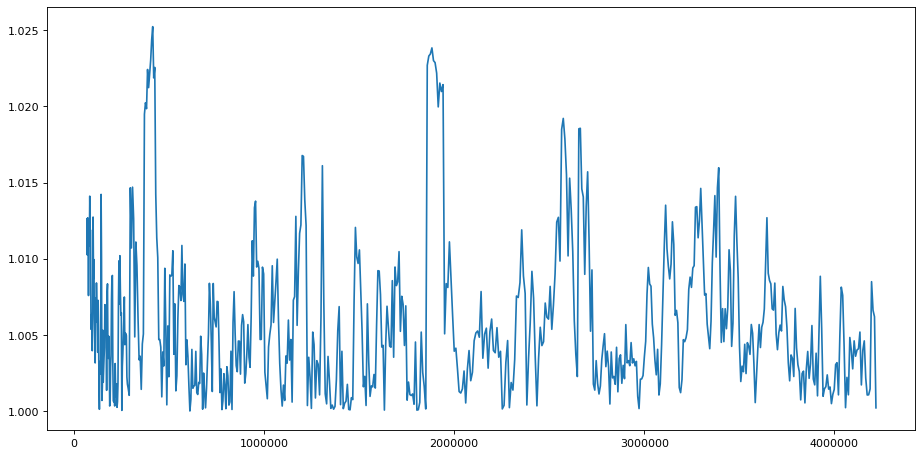

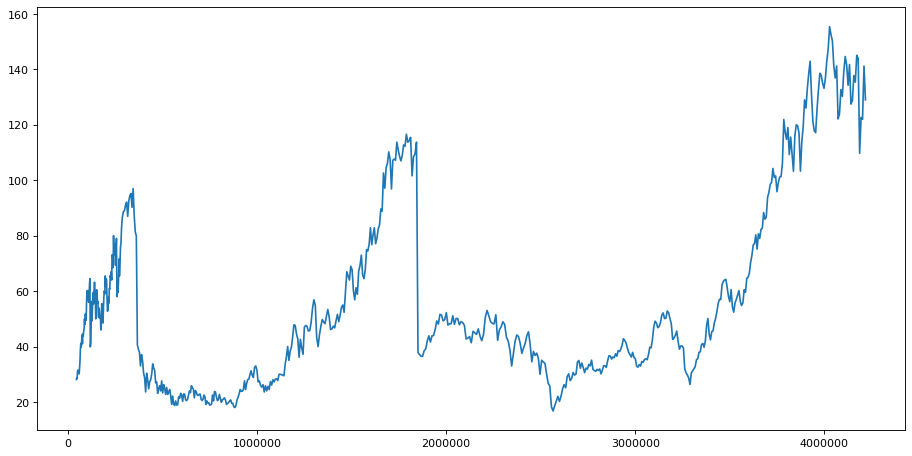

In [68]:
fig=plt.figure(figsize=(14, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(df[df.PERMNO == 40272].index, df[df.PERMNO == 40272]['momentum_score'])
plt.show()
fig=plt.figure(figsize=(14, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(df[df.PERMNO == 40272].index, df[df.PERMNO == 40272]['PRC'])

In [69]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df[df.PERMNO == 31077].index,
               y=df[df.PERMNO == 31077]['rapm'],
               name="rapm"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df[df.PERMNO == 31077].index,
               y=df[df.PERMNO == 31077]['PRC'],
               name="price"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Momentum vs Price"
)

# Set x-axis title
fig.update_xaxes(title_text="time")

# Set y-axes titles
fig.update_yaxes(title_text="<b>momentum score</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>price</b> of the index", secondary_y=True)

fig.show()

In [101]:
df_group = df.groupby(['PERMNO','date'])[['EXCHCD', 'SHRCD', 'PRC', 'VOL', 'RET','SHROUT']].agg(sum)
df_group.reset_index(inplace= True)
print(df_group.nunique())

df_group = df.groupby(['PERMNO','date'])[['PRC', 'VOL', 'RET','SHROUT']].agg(sum)
df_group

PERMNO      209
date        690
EXCHCD        5
SHRCD        11
PRC       15316
VOL       76781
RET       75006
SHROUT    31021
dtype: int64


PRC       VOL       RET    SHROUT
PERMNO date                                          
10065  1962-07   24.875     167.0  0.015306    3444.0
       1962-08   25.000     160.0  0.011055    3444.0
       1962-09   23.500     137.0 -0.060000    3444.0
       1962-10   23.375     205.0 -0.005319    3444.0
       1962-11   24.750     262.0  0.108449    3444.0
...                 ...       ...       ...       ...
40272  2019-08  109.750  357759.0 -0.237794  106775.0
       2019-09  122.690  243269.0  0.124738  106775.0
       2019-10  122.010  209595.0 -0.005542  106775.0
       2019-11  141.230  199351.0  0.157528  106776.0
       2019-12  129.020  325005.0 -0.081144  106781.0

[143983 rows x 4 columns]

I. Selectionner 10 stocks
For each stocks :
    2. Return sur 12 mois
    3. Vol de chaque stocks
    4. Risk-adjusted Price Momentum = Price Momentum / σ
    5. Compute Momentum Z-Score : z = (Risk-adjusted Price Momentum - μ) / σ
    6. The Momentum Score is then computed from the Momentum Z-Score as follows:
        𝑀𝑜𝑚𝑒𝑛𝑡𝑢𝑚 𝑆𝑐𝑜𝑟𝑒 = {
            1 + 𝑍         if  𝑍 > 0
            (1 − 𝑍)**-1   if  𝑍 < 0
            }
            
https://www.msci.com/eqb/methodology/meth_docs/MSCI_Momentum_Indexes_Methodology_May2017.pdf

https://www.investopedia.com/articles/technical/081501.asp

In [83]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221415 entries, 0 to 4221414
Data columns (total 9 columns):
index     int64
PERMNO    int64
date      object
SHRCD     float64
EXCHCD    float64
PRC       float64
VOL       float64
RET       float64
SHROUT    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 289.9+ MB


## Question 6 :
Using one of the six strategies described above, each group will create a monthly
trading strategy and form 10 portfolios (both equally- and value-weighted).


In [53]:
fama_french_3.head()

,Mkt-RF,SMB,HML,RF
1926-07-01,2.96,-2.30,-2.87,0.22
1926-08-01,2.64,-1.40,4.19,0.25
1926-09-01,0.36,-1.32,0.01,0.23
1926-10-01,-3.24,0.04,0.51,0.32
1926-11-01,2.53,-0.20,-0.35,0.31


## Question 7 :
Finally, the raw return, CAPM alpha, Fama-French 3-factor alpha and Fama-French 5-
factor alpha of the 10 portfolios as well as the arbitrage portfolio that is long in
portfolio 10 and short in portfolio 1 will be reported.

The Formula for the Fama French Model Is:
\begin{aligned} &R_{it} - R_{ft} = \alpha_{it} + \beta_1 ( R_{Mt} - R_{ft} ) + \beta_2SMB_t + \beta_3HML_t + \epsilon_{it} \\ &\textbf{where:} \\ &R_{it} = \text{total return of a stock or portfolio } i \text{ at time } t \\ &R_{ft} = \text{risk free rate of return at time } t \\ &R_{Mt} = \text{total market portfolio return at time } t \\ &R_{it} - R_{ft} = \text{expected excess return} \\ &R_{Mt} - R_{ft} = \text{excess return on the market portfolio (index)} \\ &SMB_t = \text{size premium (small minus big)} \\ &HML_t = \text{value premium (high minus low)} \\ &\beta_{1,2,3} = \text{factor coefficients} \\ \end{aligned} 


In [70]:
import statsmodels.formula.api as sm # module for stats models
from statsmodels.iolib.summary2 import summary_col # module for presenting stats models outputs nicely

In [72]:
import pandas_datareader.data as web  # module for reading datasets directly from the web
df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench')[0]
df_factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2015-03-30,1.24,0.06,-0.04,-0.26,0.01,0.000
2015-03-31,-0.75,0.45,0.38,0.17,0.26,0.000
2015-04-01,-0.38,0.34,0.43,-0.17,0.25,0.000
2015-04-02,0.35,-0.10,0.31,-0.12,0.25,0.000
2015-04-06,0.61,-0.28,-0.15,0.22,-0.22,0.000
...,...,...,...,...,...,...
2020-02-24,-3.38,0.15,-0.04,-0.37,0.20,0.006
2020-02-25,-3.09,-0.34,-0.72,-0.63,0.03,0.006
2020-02-26,-0.52,-0.79,-1.26,-0.52,-0.12,0.006


In [ ]:
def assetPriceReg(df_stk):
    
    fama_french_3 = pd.read_csv("F-F_Research_Data_Factors.CSV", index_col='Unnamed: 0', skiprows=3)
    fama_french_3 = fama_french_3[:1124]
    fama_french_3.index = pd.to_datetime(fama_french_3.index, format="%Y%m")
    
    # Reading in factor data
    
    fama_french_3.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    fama_french_3['MKT'] = df_factors['MKT']/100
    fama_french_3['SMB'] = df_factors['SMB']/100
    fama_french_3['HML'] = df_factors['HML']/100
    
    df_stock_factor = pd.merge(df_stk,df_factors,left_index=True,right_index=True) # Merging the stock and factor returns dataframes together
    df_stock_factor['XsRet'] = df_stock_factor['annual_return'] - df_stock_factor['RF'] # Calculating excess returns

    # Running CAPM, FF3, and FF5 models.
    CAPM = sm.ols(formula = 'XsRet ~ MKT', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF3 = sm.ols( formula = 'XsRet ~ MKT + SMB + HML', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF5 = sm.ols( formula = 'XsRet ~ MKT + SMB + HML + RMW + CMA', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})

    CAPMtstat = CAPM.tvalues
    FF3tstat = FF3.tvalues
    FF5tstat = FF5.tvalues

    CAPMcoeff = CAPM.params
    FF3coeff = FF3.params
    FF5coeff = FF5.params

    # DataFrame with coefficients and t-stats
    results_df = pd.DataFrame({'CAPMcoeff':CAPMcoeff,'CAPMtstat':CAPMtstat,
                               'FF3coeff':FF3coeff, 'FF3tstat':FF3tstat,
                               'FF5coeff':FF5coeff, 'FF5tstat':FF5tstat},
    index = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])


    dfoutput = summary_col([CAPM,FF3, FF5],stars=True,float_format='%0.4f',
                  model_names=['CAPM','FF3','FF5'],
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'Adjusted R2':lambda x: "{:.4f}".format(x.rsquared_adj)}, 
                             regressor_order = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])

    print(dfoutput)
    
    return results_df

In [54]:
# appliquer la fonction pour chaque row : .apply
def fama_french_3(df) :
    alpha = df.return - df.rf - SMB* - HML

SyntaxError: invalid syntax (<ipython-input-54-bd8604a14d36>, line 3)